In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import gc
import scipy as sp
import os
import sys
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input,Dense, Dropout, Activation,concatenate
from keras.regularizers import l1,l2,l1_l2

Using TensorFlow backend.


In [2]:
# Definitions
data_dir = "/home/slow-storage/Kaggle/Earthquake/"
train_file = data_dir + "train.csv"
test_dir = data_dir + "/test/"

In [3]:
def augment_data(df,x,index):
   
    first_segments = [10000,50000]
    last_segments  = [10000,50000]
    mid_segments   = [30000,50000]
    
    quantiles=[0.01,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,
               0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.85,0.90,0.95,0.99]
    
    z = np.fft.fft(x)
    realFFT = np.real(z)
    imagFFT = np.imag(z)
    
    for f_seg in first_segments:
        first_set = x[:f_seg]
        df.loc[index, 'std_first_{}'.format(f_seg)] = x[:f_seg].std()
        df.loc[index, 'mean_first_{}'.format(f_seg)] = x[:f_seg].mean()
        df.loc[index, 'Rstd_first_{}'.format(f_seg)] = realFFT[:f_seg].std()
        df.loc[index, 'Rmean_first_{}'.format(f_seg)] = realFFT[:f_seg].mean()
        df.loc[index, 'mean_first_{}'.format(f_seg)] = first_set.mean()
        df.loc[index, 'std_first_{}'.format(f_seg)] = first_set.std()
        df.loc[index, 'var_first_{}'.format(f_seg)] = first_set.var()
        df.loc[index, 'max_first_{}'.format(f_seg)] = first_set.max()
        df.loc[index, 'min_first_{}'.format(f_seg)] = first_set.min()
        df.loc[index, 'sum_first_{}'.format(f_seg)] = first_set.sum()
        df.loc[index, 'ptp_first_{}'.format(f_seg)] = np.ptp(first_set)
        df.loc[index, 'abs_max_first_{}'.format(f_seg)] = np.abs(first_set).max()
        df.loc[index, 'abs_min_first_{}'.format(f_seg)] = np.abs(first_set).min()
        df.loc[index, 'mean_change_abs_first_{}'.format(f_seg)] = np.mean(np.diff(first_set))
        df.loc[index, 'abs_mean_first_{}'.format(f_seg)] = np.abs(first_set).mean()
        df.loc[index, 'abs_std_first_{}'.format(f_seg)] = np.abs(first_set).std()
        df.loc[index, 'Hilbert_mean_first_{}'.format(f_seg)] = np.abs(hilbert(first_set)).mean()
        df.loc[index, 'max_to_min_first_{}'.format(f_seg)] = first_set.max() / np.abs(first_set.min())
        df.loc[index, 'max_to_min_diff_first_{}'.format(f_seg)] = first_set.max() - np.abs(first_set.min())
        df.loc[index, 'skew_first_{}'.format(f_seg)]      = sp.stats.skew(first_set)
        df.loc[index, 'kurtosis_first_{}'.format(f_seg)]  = sp.stats.kurtosis(first_set)
        df.loc[index, 'entropy_first_{}'.format(f_seg)]   = sp.stats.entropy(first_set)
        df.loc[index, 'sem_first_{}'.format(f_seg)]       = sp.stats.sem(first_set, axis=None, ddof=0)
        df.loc[index, 'trim_mean_first_{}'.format(f_seg)] = sp.stats.trim_mean(first_set, 0.1)
        df.loc[index, 'variation_first_{}'.format(f_seg)] = sp.stats.variation(first_set)
        df.loc[index, 'gmean_first_{}'.format(f_seg)]     = sp.stats.gmean(first_set)
        df.loc[index, 'tmean_first_{}'.format(f_seg)]     = sp.stats.tmean(first_set)
        df.loc[index, 'tstd_first_{}'.format(f_seg)]      = sp.stats.tstd(first_set)
        df.loc[index, 'tsem_first_{}'.format(f_seg)]      = sp.stats.tsem(first_set)
        df.loc[index, 'kstat_1_first_{}'.format(f_seg)]   = sp.stats.kstat(first_set, 1)
        df.loc[index, 'kstat_2_first_{}'.format(f_seg)]   = sp.stats.kstat(first_set, 2)
        df.loc[index, 'kstat_3_first_{}'.format(f_seg)]   = sp.stats.kstat(first_set, 3)
        df.loc[index, 'kstat_4_first_{}'.format(f_seg)]   = sp.stats.kstat(first_set, 4)
        df.loc[index, 'moment_1_first_{}'.format(f_seg)]  = sp.stats.moment(first_set, 1)
        df.loc[index, 'moment_2_first_{}'.format(f_seg)]  = sp.stats.moment(first_set, 2)
        df.loc[index, 'moment_3_first_{}'.format(f_seg)]  = sp.stats.moment(first_set, 3)
        df.loc[index, 'moment_4_first_{}'.format(f_seg)]  = sp.stats.moment(first_set, 4)
    
        for n in quantiles:
            df.loc[index, 'abs_q_first_{}_{}'.format(n,f_seg)] = np.quantile(np.abs(first_set), n)
    
        for n in quantiles:
            df.loc[index, 'q_first_{}_{}'.format(n,f_seg)] = np.quantile(first_set, n)
            
            
    for l_seg in last_segments:
        last_set = x[-l_seg:]
        df.loc[index, 'std_last_{}'.format(l_seg)] = last_set.std()
        df.loc[index, 'mean_last_{}'.format(l_seg)] = last_set.mean()
        df.loc[index, 'Rstd_last_{}'.format(l_seg)] = realFFT[-l_seg:].std()
        df.loc[index, 'Rmean_last_{}'.format(l_seg)] = realFFT[-l_seg:].mean()
        df.loc[index, 'mean_last_{}'.format(l_seg)] = last_set.mean()
        df.loc[index, 'std_last_{}'.format(l_seg)] = last_set.std()
        df.loc[index, 'var_last_{}'.format(l_seg)] = last_set.var()
        df.loc[index, 'max_last_{}'.format(l_seg)] = last_set.max()
        df.loc[index, 'min_last_{}'.format(l_seg)] = last_set.min()
        df.loc[index, 'sum_last_{}'.format(l_seg)] = last_set.sum()
        df.loc[index, 'ptp_last_{}'.format(l_seg)] = np.ptp(last_set)
        df.loc[index, 'abs_max_last_{}'.format(l_seg)] = np.abs(last_set).max()
        df.loc[index, 'abs_min_last_{}'.format(l_seg)] = np.abs(last_set).min()
        df.loc[index, 'mean_change_abs_last_{}'.format(l_seg)] = np.mean(np.diff(last_set))
        df.loc[index, 'abs_mean_last_{}'.format(l_seg)] = np.abs(last_set).mean()
        df.loc[index, 'abs_std_last_{}'.format(l_seg)] = np.abs(last_set).std()
        df.loc[index, 'Hilbert_mean_last_{}'.format(l_seg)] = np.abs(hilbert(last_set)).mean()
        df.loc[index, 'max_to_min_last_{}'.format(l_seg)] = last_set.max() / np.abs(last_set.min())
        df.loc[index, 'max_to_min_diff_last_{}'.format(l_seg)] = last_set.max() - np.abs(last_set.min())
        df.loc[index, 'skew_last_{}'.format(l_seg)]      = sp.stats.skew(last_set)
        df.loc[index, 'kurtosis_last_{}'.format(l_seg)]  = sp.stats.kurtosis(last_set)
        df.loc[index, 'entropy_last_{}'.format(l_seg)]   = sp.stats.entropy(last_set)
        df.loc[index, 'sem_last_{}'.format(l_seg)]       = sp.stats.sem(last_set, axis=None, ddof=0)
        df.loc[index, 'trim_mean_last_{}'.format(l_seg)] = sp.stats.trim_mean(last_set, 0.1)
        df.loc[index, 'variation_last_{}'.format(l_seg)] = sp.stats.variation(last_set)
        df.loc[index, 'gmean_last_{}'.format(l_seg)]     = sp.stats.gmean(last_set)
        df.loc[index, 'tmean_last_{}'.format(l_seg)]     = sp.stats.tmean(last_set)
        df.loc[index, 'tstd_last_{}'.format(l_seg)]      = sp.stats.tstd(last_set)
        df.loc[index, 'tsem_last_{}'.format(l_seg)]      = sp.stats.tsem(last_set)
        df.loc[index, 'kstat_1_last_{}'.format(l_seg)]   = sp.stats.kstat(last_set, 1)
        df.loc[index, 'kstat_2_last_{}'.format(l_seg)]   = sp.stats.kstat(last_set, 2)
        df.loc[index, 'kstat_3_last_{}'.format(l_seg)]   = sp.stats.kstat(last_set, 3)
        df.loc[index, 'kstat_4_last_{}'.format(l_seg)]   = sp.stats.kstat(last_set, 4)
        df.loc[index, 'moment_1_last_{}'.format(l_seg)]  = sp.stats.moment(last_set, 1)
        df.loc[index, 'moment_2_last_{}'.format(l_seg)]  = sp.stats.moment(last_set, 2)
        df.loc[index, 'moment_3_last_{}'.format(l_seg)]  = sp.stats.moment(last_set, 3)
        df.loc[index, 'moment_4_last_{}'.format(l_seg)]  = sp.stats.moment(last_set, 4)
    
        for n in quantiles:
            df.loc[index, 'abs_q_last_{}_{}'.format(n,l_seg)] = np.quantile(np.abs(last_set), n)
    
        for n in quantiles:
            df.loc[index, 'q_last_{}_{}'.format(n,l_seg)] = np.quantile(last_set, n)
    
    for m_seg in mid_segments:
        mid_set = x[m_seg:-m_seg]
        df.loc[index, 'std_mid_{}'.format(m_seg)] = mid_set.std()
        df.loc[index, 'mean_mid_{}'.format(m_seg)] = mid_set.mean()
        df.loc[index, 'Rstd_mid_{}'.format(m_seg)] = realFFT[-m_seg:m_seg].std()
        df.loc[index, 'Rmean_mid_{}'.format(m_seg)] = realFFT[-m_seg:m_seg].mean()     
        df.loc[index, 'mean_mid_{}'.format(m_seg)] = mid_set.mean()
        df.loc[index, 'std_mid_{}'.format(m_seg)] = mid_set.std()
        df.loc[index, 'var_mid_{}'.format(m_seg)] = mid_set.var()
        df.loc[index, 'max_mid_{}'.format(m_seg)] = mid_set.max()
        df.loc[index, 'min_mid_{}'.format(m_seg)] = mid_set.min()
        df.loc[index, 'sum_mid_{}'.format(m_seg)] = mid_set.sum()
        df.loc[index, 'ptp_mid_{}'.format(m_seg)] = np.ptp(mid_set)
        df.loc[index, 'abs_max_mid_{}'.format(m_seg)] = np.abs(mid_set).max()
        df.loc[index, 'abs_min_mid_{}'.format(m_seg)] = np.abs(mid_set).min()
        df.loc[index, 'mean_change_abs_mid_{}'.format(m_seg)] = np.mean(np.diff(mid_set))
        df.loc[index, 'abs_mean_mid_{}'.format(m_seg)] = np.abs(mid_set).mean()
        df.loc[index, 'abs_std_mid_{}'.format(m_seg)] = np.abs(mid_set).std()
        df.loc[index, 'Hilbert_mean_mid_{}'.format(m_seg)] = np.abs(hilbert(mid_set)).mean()
        df.loc[index, 'max_to_min_mid_{}'.format(m_seg)] = mid_set.max() / np.abs(mid_set.min())
        df.loc[index, 'max_to_min_diff_mid_{}'.format(m_seg)] = mid_set.max() - np.abs(mid_set.min())
        df.loc[index, 'skew_mid_{}'.format(m_seg)]      = sp.stats.skew(mid_set)
        df.loc[index, 'kurtosis_mid_{}'.format(m_seg)]  = sp.stats.kurtosis(mid_set)
        df.loc[index, 'entropy_mid_{}'.format(m_seg)]   = sp.stats.entropy(mid_set)
        df.loc[index, 'sem_mid_{}'.format(m_seg)]       = sp.stats.sem(mid_set, axis=None, ddof=0)
        df.loc[index, 'trim_mean_mid_{}'.format(m_seg)] = sp.stats.trim_mean(mid_set, 0.1)
        df.loc[index, 'variation_mid_{}'.format(m_seg)] = sp.stats.variation(mid_set)
        df.loc[index, 'gmean_mid_{}'.format(m_seg)]     = sp.stats.gmean(mid_set)
        df.loc[index, 'tmean_mid_{}'.format(m_seg)]     = sp.stats.tmean(mid_set)
        df.loc[index, 'tstd_mid_{}'.format(m_seg)]      = sp.stats.tstd(mid_set)
        df.loc[index, 'tsem_mid_{}'.format(m_seg)]      = sp.stats.tsem(mid_set)
        df.loc[index, 'kstat_1_mid_{}'.format(m_seg)]   = sp.stats.kstat(mid_set, 1)
        df.loc[index, 'kstat_2_mid_{}'.format(m_seg)]   = sp.stats.kstat(mid_set, 2)
        df.loc[index, 'kstat_3_mid_{}'.format(m_seg)]   = sp.stats.kstat(mid_set, 3)
        df.loc[index, 'kstat_4_mid_{}'.format(m_seg)]   = sp.stats.kstat(mid_set, 4)
        df.loc[index, 'moment_1_mid_{}'.format(m_seg)]  = sp.stats.moment(mid_set, 1)
        df.loc[index, 'moment_2_mid_{}'.format(m_seg)]  = sp.stats.moment(mid_set, 2)
        df.loc[index, 'moment_3_mid_{}'.format(m_seg)]  = sp.stats.moment(mid_set, 3)
        df.loc[index, 'moment_4_mid_{}'.format(m_seg)]  = sp.stats.moment(mid_set, 4)
    
        for n in quantiles:
            df.loc[index, 'abs_q_mid_{}_{}'.format(n,m_seg)] = np.quantile(np.abs(mid_set), n)
    
        for n in quantiles:
            df.loc[index, 'q_mid_{}_{}'.format(n,m_seg)] = np.quantile(mid_set, n)

    #Get Statistics on Whole segment
    df.loc[index, 'Real_mean'] = realFFT.mean()
    df.loc[index, 'Real_std'] = realFFT.std()
    df.loc[index, 'Imag_mean'] = imagFFT.mean()
    df.loc[index, 'Imag_std'] = imagFFT.std()
    df.loc[index, 'mean'] = x.mean()
    df.loc[index, 'std'] = x.std()
    df.loc[index, 'var'] = x.var()
    df.loc[index, 'max'] = x.max()
    df.loc[index, 'min'] = x.min()
    df.loc[index, 'sum'] = x.sum()
    df.loc[index, 'ptp'] = np.ptp(x)
    df.loc[index, 'abs_max'] = np.abs(x).max()
    df.loc[index, 'abs_min'] = np.abs(x).min()
    df.loc[index, 'mean_change_abs'] = np.mean(np.diff(x))
    df.loc[index, 'abs_mean'] = np.abs(x).mean()
    df.loc[index, 'abs_std'] = np.abs(x).std()
    df.loc[index, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    df.loc[index, 'max_to_min'] = x.max() / np.abs(x.min())
    df.loc[index, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    df.loc[index, 'skew']      = sp.stats.skew(x)
    df.loc[index, 'kurtosis']  = sp.stats.kurtosis(x)
    df.loc[index, 'entropy']   = sp.stats.entropy(x)
    df.loc[index, 'sem']       = sp.stats.sem(x, axis=None, ddof=0)
    df.loc[index, 'trim_mean'] = sp.stats.trim_mean(x, 0.1)
    df.loc[index, 'variation'] = sp.stats.variation(x)
    df.loc[index, 'gmean']     = sp.stats.gmean(x)
    df.loc[index, 'tmean']     = sp.stats.tmean(x)
    df.loc[index, 'tstd']      = sp.stats.tstd(x)
    df.loc[index, 'tsem']      = sp.stats.tsem(x)
    df.loc[index, 'kstat_1']   = sp.stats.kstat(x, 1)
    df.loc[index, 'kstat_2']   = sp.stats.kstat(x, 2)
    df.loc[index, 'kstat_3']   = sp.stats.kstat(x, 3)
    df.loc[index, 'kstat_4']   = sp.stats.kstat(x, 4)
    df.loc[index, 'moment_1']  = sp.stats.moment(x, 1)
    df.loc[index, 'moment_2']  = sp.stats.moment(x, 2)
    df.loc[index, 'moment_3']  = sp.stats.moment(x, 3)
    df.loc[index, 'moment_4']  = sp.stats.moment(x, 4)
    
    for n in quantiles:
        df.loc[index, 'abs_q{}'.format(n)] = np.quantile(np.abs(x), n)
    
    for n in quantiles:
        df.loc[index, 'q{}'.format(n)] = np.quantile(x, n)



In [4]:
x_traindf = pd.read_csv(data_dir+'trainx_augment.csv')
y_traindf = pd.read_csv(data_dir+'trainy_augment.csv')

In [5]:
rows = 150000
chunk = int(np.floor(x_traindf.shape[0] / rows))

In [6]:
pd.options.mode.use_inf_as_na = True

# Drop columns with too many NaNs 
x_traindf = x_traindf.dropna(axis='columns',thresh=100)
x_traindf = x_traindf.fillna(0)

In [7]:
firstdf  = x_traindf.loc[:, x_traindf.columns.str.contains('first')]
middledf = x_traindf.loc[:, x_traindf.columns.str.contains('mid')]
lastdf   = x_traindf.loc[:, x_traindf.columns.str.contains('last')]

In [8]:
print(firstdf.shape,middledf.shape,lastdf.shape)
lastdf = lastdf[lastdf.columns.drop(list(lastdf.filter(regex='Rmean')))]
lastdf = lastdf[lastdf.columns.drop(list(lastdf.filter(regex='Rstd')))]
print(firstdf.shape,middledf.shape,lastdf.shape)


(62906, 146) (62906, 146) (62906, 150)
(62906, 146) (62906, 146) (62906, 146)


In [9]:
x1 = firstdf.to_numpy()
x2 = middledf.to_numpy()
x3 = lastdf.to_numpy()

y = y_traindf.to_numpy()
y = y.flatten()

print("Number of Samples: ", x1.shape[0],x2.shape[0],x3.shape[0],
      "\nNumber of Features: ", x1.shape[1],x2.shape[1],x3.shape[1])

columns = x_traindf.columns

Number of Samples:  62906 62906 62906 
Number of Features:  146 146 146


### Scaling Data

The StandardScaler() function Scikit Learn standardizes the data by removing the mean and unit variance.

In [10]:
scaler = StandardScaler()
scaler.fit(x1)
scaled_x1 = scaler.transform(x1)
scaled_x2 = scaler.transform(x2)
scaled_x3 = scaler.transform(x3)

### Preparing Train and Test Sets

80% of the data will be used for the training set, and 20% will be used for the testing set.  The data will be shuffled to help prevent overfitting.

In [11]:
print(scaled_x1.shape,scaled_x2.shape,scaled_x3.shape)

(62906, 146) (62906, 146) (62906, 146)


In [40]:
inputA = Input(shape=(scaled_x1.shape[1],))
inputB = Input(shape=(scaled_x2.shape[1],))
inputC = Input(shape=(scaled_x3.shape[1],))
    
# Data from first part of segment
a = Dense(512,activation='relu')(inputA)
a = Dropout(.3)(a)
a = Dense(256,activation='relu')(a)
a = Dropout(.3)(a)
a = Dense(128,activation='relu')(a)
a = Dropout(.3)(a)
a = Dense(64,activation='relu')(a)
a = Model(inputs=inputA,outputs=a)
 
# Data from middle part of segment
b = Dense(512,activation='relu')(inputB) 
b = Dropout(.3)(b)
b = Dense(256,activation='relu')(b)
b = Dropout(.3)(b)
b = Dense(128,activation='relu')(b)
b = Dropout(.3)(b)
b = Dense(64,activation='relu')(b)
b = Model(inputs=inputB,outputs=b)
 
# Data from last part of segment
c = Dense(512,activation='relu')(inputC) 
c = Dropout(.3)(c)
c = Dense(256,activation='relu')(c)
c = Dropout(.3)(c)
c = Dense(128,activation='relu')(c)
c = Dropout(.3)(c)
c = Dense(64,activation='relu')(c)
c = Model(inputs=inputC,outputs=c)

combined = concatenate([a.output,b.output,c.output])

final = Dense(1024,activation='relu')(combined)
final = Dropout(.3)(final)
final = Dense(512,activation='relu')(final)
final = Dropout(.3)(final)
final = Dense(256,activation='relu')(final)
final = Dropout(.3)(final)
final = Dense(128,activation='relu')(final)
final = Dropout(.3)(final)
final = Dense(64,activation='relu')(final)
final = Dropout(.3)(final)
final = Dense(32,activation='relu')(final)
final = Dropout(.3)(final)
final = Dense(16,activation='relu')(final)
final = Dense(1, activation="linear")(final)
    
model = Model(inputs=[a.input,b.input,c.input], outputs=final)
    

In [41]:
optim = Adam(lr = 0.01)

model.compile(loss='mae', optimizer=optim,metrics=['mae','mse'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 146)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 146)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 146)          0                                            
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 512)          75264       input_7[0][0]                    
__________________________________________________________________________________________________
dense_38 (

In [42]:
best_model = data_dir + 'dense' + '_weights_best.hdf5'
current_model = data_dir + 'dense' + '_weights_current.hdf5'

checkpoint = ModelCheckpoint(best_model, 
                             monitor="loss",
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

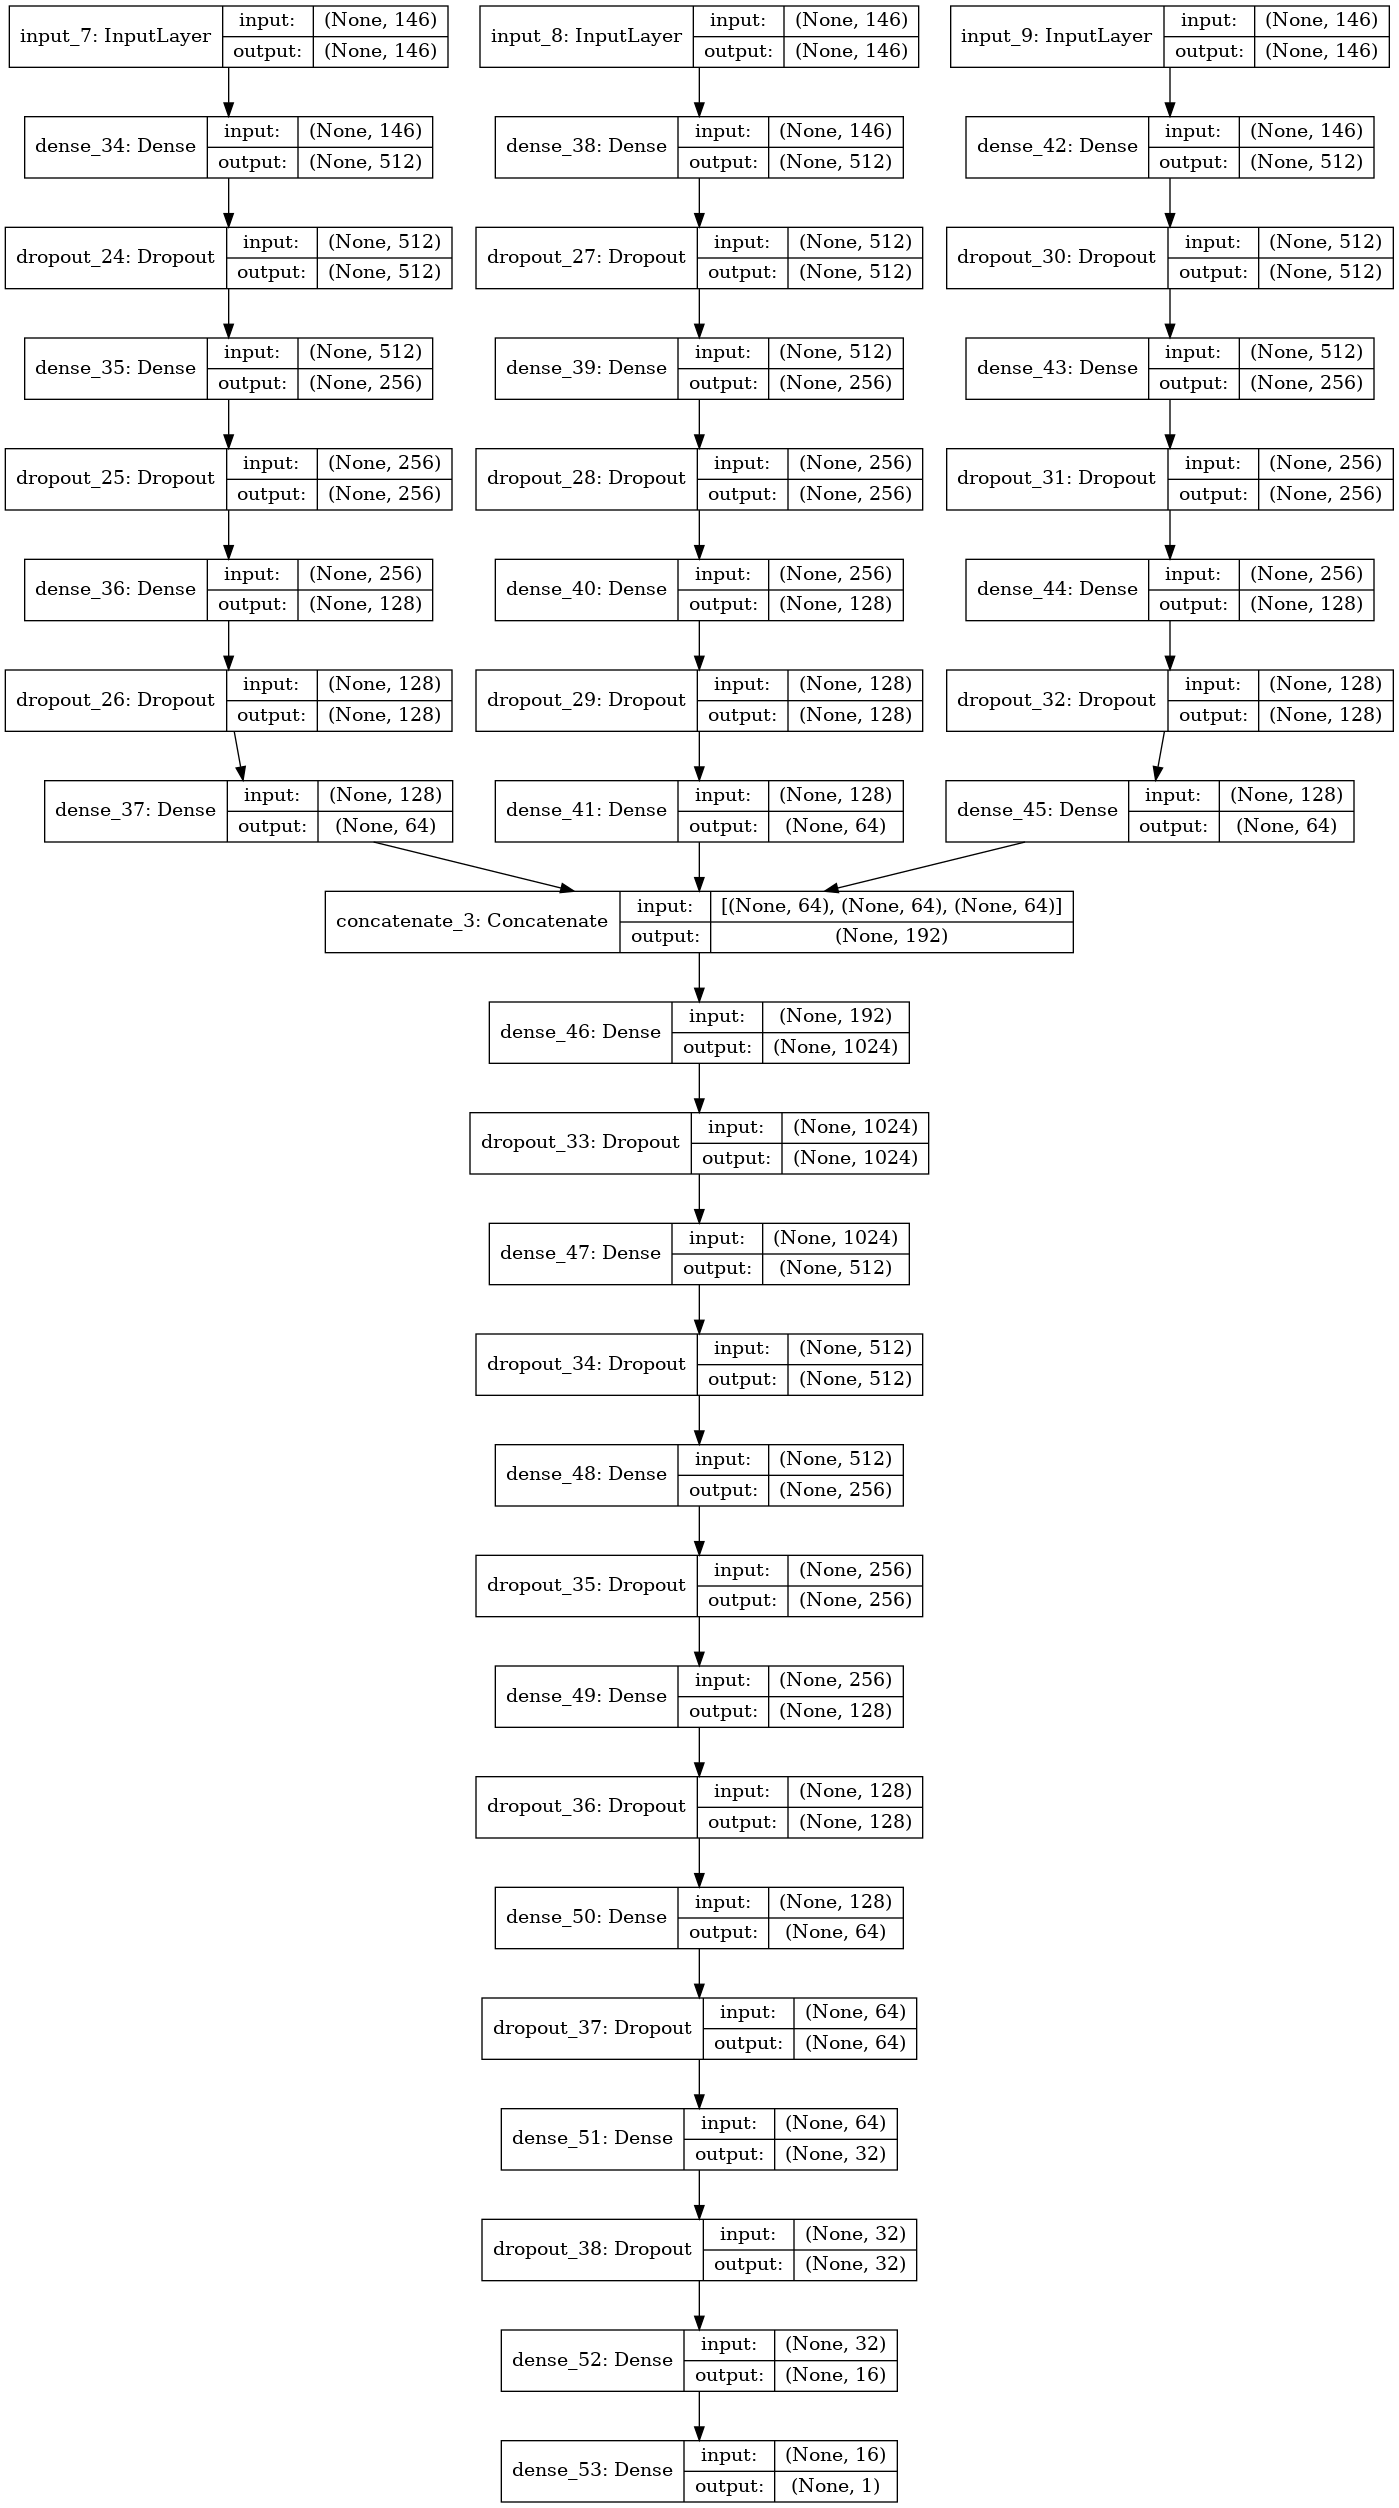

In [43]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [45]:
history = model.fit([scaled_x1,scaled_x2,scaled_x3],y,
                    batch_size=300,
                    epochs=600,
                    verbose=1,
                    shuffle=True,        
                    callbacks=callbacks_list
                   )

Epoch 1/600
62906/62906 [==============================] - 2s 35us/step - loss: 2.4402 - mean_absolute_error: 2.4402 - mean_squared_error: 10.8764

Epoch 00001: loss improved from 61.65734 to 2.44015, saving model to /home/slow-storage/Kaggle/Earthquake/dense_weights_best.hdf5
Epoch 2/600
62906/62906 [==============================] - 2s 35us/step - loss: 2.4213 - mean_absolute_error: 2.4213 - mean_squared_error: 92.0295

Epoch 00002: loss improved from 2.44015 to 2.42127, saving model to /home/slow-storage/Kaggle/Earthquake/dense_weights_best.hdf5
Epoch 3/600
62906/62906 [==============================] - 2s 36us/step - loss: 2.3657 - mean_absolute_error: 2.3657 - mean_squared_error: 9.5086

Epoch 00003: loss improved from 2.42127 to 2.36573, saving model to /home/slow-storage/Kaggle/Earthquake/dense_weights_best.hdf5
Epoch 4/600
62906/62906 [==============================] - 2s 37us/step - loss: 2.3386 - mean_absolute_error: 2.3386 - mean_squared_error: 9.4721

Epoch 00004: loss impr

62906/62906 [==============================] - 2s 35us/step - loss: 3.0394 - mean_absolute_error: 3.0394 - mean_squared_error: 13.6119

Epoch 00041: loss did not improve from 2.33860
Epoch 42/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0395 - mean_absolute_error: 3.0395 - mean_squared_error: 13.5963

Epoch 00042: loss did not improve from 2.33860
Epoch 43/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0390 - mean_absolute_error: 3.0390 - mean_squared_error: 13.6059

Epoch 00043: loss did not improve from 2.33860
Epoch 44/600
62906/62906 [==============================] - 2s 34us/step - loss: 3.0836 - mean_absolute_error: 3.0836 - mean_squared_error: 135.2969

Epoch 00044: loss did not improve from 2.33860
Epoch 45/600
62906/62906 [==============================] - 2s 33us/step - loss: 3.2456 - mean_absolute_error: 3.2456 - mean_squared_error: 2095.2461

Epoch 00045: loss did not improve from 2.33860
Epoch 46/600
62906/62906 [====

62906/62906 [==============================] - 2s 35us/step - loss: 3.0392 - mean_absolute_error: 3.0392 - mean_squared_error: 13.6036

Epoch 00083: loss did not improve from 2.33860
Epoch 84/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0394 - mean_absolute_error: 3.0394 - mean_squared_error: 13.6113

Epoch 00084: loss did not improve from 2.33860
Epoch 85/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0393 - mean_absolute_error: 3.0393 - mean_squared_error: 13.6168

Epoch 00085: loss did not improve from 2.33860
Epoch 86/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0395 - mean_absolute_error: 3.0395 - mean_squared_error: 13.6092

Epoch 00086: loss did not improve from 2.33860
Epoch 87/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0404 - mean_absolute_error: 3.0404 - mean_squared_error: 13.6184

Epoch 00087: loss did not improve from 2.33860
Epoch 88/600
62906/62906 [=======


Epoch 00124: loss did not improve from 2.33860
Epoch 125/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0395 - mean_absolute_error: 3.0395 - mean_squared_error: 13.6228

Epoch 00125: loss did not improve from 2.33860
Epoch 126/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0396 - mean_absolute_error: 3.0396 - mean_squared_error: 13.6113

Epoch 00126: loss did not improve from 2.33860
Epoch 127/600
62906/62906 [==============================] - 2s 34us/step - loss: 3.0392 - mean_absolute_error: 3.0392 - mean_squared_error: 13.6058

Epoch 00127: loss did not improve from 2.33860
Epoch 128/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0399 - mean_absolute_error: 3.0399 - mean_squared_error: 13.6184

Epoch 00128: loss did not improve from 2.33860
Epoch 129/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0394 - mean_absolute_error: 3.0394 - mean_squared_error: 13.6164

Epoch 00129: l

62906/62906 [==============================] - 2s 37us/step - loss: 3.0389 - mean_absolute_error: 3.0389 - mean_squared_error: 13.6100

Epoch 00166: loss did not improve from 2.33860
Epoch 167/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0412 - mean_absolute_error: 3.0412 - mean_squared_error: 14.0340

Epoch 00167: loss did not improve from 2.33860
Epoch 168/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0394 - mean_absolute_error: 3.0394 - mean_squared_error: 13.6099

Epoch 00168: loss did not improve from 2.33860
Epoch 169/600
62906/62906 [==============================] - 3s 43us/step - loss: 6.0178 - mean_absolute_error: 6.0178 - mean_squared_error: 558228.6698

Epoch 00169: loss did not improve from 2.33860
Epoch 170/600
62906/62906 [==============================] - 2s 40us/step - loss: 3.0389 - mean_absolute_error: 3.0389 - mean_squared_error: 13.6035

Epoch 00170: loss did not improve from 2.33860
Epoch 171/600
62906/62906

62906/62906 [==============================] - 2s 34us/step - loss: 3.8669 - mean_absolute_error: 3.8669 - mean_squared_error: 42220.5202

Epoch 00207: loss did not improve from 2.33860
Epoch 208/600
62906/62906 [==============================] - 3s 41us/step - loss: 3.0387 - mean_absolute_error: 3.0387 - mean_squared_error: 13.6035

Epoch 00208: loss did not improve from 2.33860
Epoch 209/600
62906/62906 [==============================] - 3s 42us/step - loss: 3.0390 - mean_absolute_error: 3.0390 - mean_squared_error: 13.5978

Epoch 00209: loss did not improve from 2.33860
Epoch 210/600
62906/62906 [==============================] - 3s 42us/step - loss: 3.0388 - mean_absolute_error: 3.0388 - mean_squared_error: 13.6099

Epoch 00210: loss did not improve from 2.33860
Epoch 211/600
62906/62906 [==============================] - 2s 36us/step - loss: 3.0393 - mean_absolute_error: 3.0393 - mean_squared_error: 13.6108

Epoch 00211: loss did not improve from 2.33860
Epoch 212/600
62906/62906 

62906/62906 [==============================] - 2s 39us/step - loss: 3.0391 - mean_absolute_error: 3.0391 - mean_squared_error: 13.5950

Epoch 00248: loss did not improve from 2.33860
Epoch 249/600
62906/62906 [==============================] - 3s 40us/step - loss: 3.0386 - mean_absolute_error: 3.0386 - mean_squared_error: 13.6084

Epoch 00249: loss did not improve from 2.33860
Epoch 250/600
62906/62906 [==============================] - 2s 38us/step - loss: 3.0387 - mean_absolute_error: 3.0387 - mean_squared_error: 13.6016

Epoch 00250: loss did not improve from 2.33860
Epoch 251/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0385 - mean_absolute_error: 3.0385 - mean_squared_error: 13.5949

Epoch 00251: loss did not improve from 2.33860
Epoch 252/600
62906/62906 [==============================] - 3s 40us/step - loss: 3.0387 - mean_absolute_error: 3.0387 - mean_squared_error: 13.5979

Epoch 00252: loss did not improve from 2.33860
Epoch 253/600
62906/62906 [==

62906/62906 [==============================] - 2s 38us/step - loss: 3.0385 - mean_absolute_error: 3.0385 - mean_squared_error: 13.5990

Epoch 00289: loss did not improve from 2.33860
Epoch 290/600
62906/62906 [==============================] - 2s 34us/step - loss: 3.0390 - mean_absolute_error: 3.0390 - mean_squared_error: 13.6134

Epoch 00290: loss did not improve from 2.33860
Epoch 291/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0390 - mean_absolute_error: 3.0390 - mean_squared_error: 13.5972

Epoch 00291: loss did not improve from 2.33860
Epoch 292/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0388 - mean_absolute_error: 3.0388 - mean_squared_error: 13.6048

Epoch 00292: loss did not improve from 2.33860
Epoch 293/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0389 - mean_absolute_error: 3.0389 - mean_squared_error: 13.6063

Epoch 00293: loss did not improve from 2.33860
Epoch 294/600
62906/62906 [==

62906/62906 [==============================] - 2s 39us/step - loss: 3.0388 - mean_absolute_error: 3.0388 - mean_squared_error: 13.6032

Epoch 00330: loss did not improve from 2.33860
Epoch 331/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0391 - mean_absolute_error: 3.0391 - mean_squared_error: 13.6001

Epoch 00331: loss did not improve from 2.33860
Epoch 332/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0389 - mean_absolute_error: 3.0389 - mean_squared_error: 13.6068

Epoch 00332: loss did not improve from 2.33860
Epoch 333/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0389 - mean_absolute_error: 3.0389 - mean_squared_error: 13.5975

Epoch 00333: loss did not improve from 2.33860
Epoch 334/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0387 - mean_absolute_error: 3.0387 - mean_squared_error: 13.6037

Epoch 00334: loss did not improve from 2.33860
Epoch 335/600
62906/62906 [==

62906/62906 [==============================] - 2s 38us/step - loss: 3.0387 - mean_absolute_error: 3.0387 - mean_squared_error: 13.6296

Epoch 00371: loss did not improve from 2.33860
Epoch 372/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0580 - mean_absolute_error: 3.0580 - mean_squared_error: 28.5807

Epoch 00372: loss did not improve from 2.33860
Epoch 373/600
62906/62906 [==============================] - 2s 38us/step - loss: 3.0386 - mean_absolute_error: 3.0386 - mean_squared_error: 13.5906

Epoch 00373: loss did not improve from 2.33860
Epoch 374/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0387 - mean_absolute_error: 3.0387 - mean_squared_error: 13.6054

Epoch 00374: loss did not improve from 2.33860
Epoch 375/600
62906/62906 [==============================] - 2s 36us/step - loss: 3.0456 - mean_absolute_error: 3.0456 - mean_squared_error: 15.1791

Epoch 00375: loss did not improve from 2.33860
Epoch 376/600
62906/62906 [==

62906/62906 [==============================] - 2s 35us/step - loss: 3.0386 - mean_absolute_error: 3.0386 - mean_squared_error: 13.6028

Epoch 00412: loss did not improve from 2.33860
Epoch 413/600
62906/62906 [==============================] - 2s 34us/step - loss: 3.0389 - mean_absolute_error: 3.0389 - mean_squared_error: 13.6011

Epoch 00413: loss did not improve from 2.33860
Epoch 414/600
62906/62906 [==============================] - 2s 33us/step - loss: 3.0386 - mean_absolute_error: 3.0386 - mean_squared_error: 13.6099

Epoch 00414: loss did not improve from 2.33860
Epoch 415/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0389 - mean_absolute_error: 3.0389 - mean_squared_error: 13.5954

Epoch 00415: loss did not improve from 2.33860
Epoch 416/600
62906/62906 [==============================] - 2s 35us/step - loss: 3.0398 - mean_absolute_error: 3.0398 - mean_squared_error: 13.6886

Epoch 00416: loss did not improve from 2.33860
Epoch 417/600
62906/62906 [==

62906/62906 [==============================] - 2s 38us/step - loss: 3.0385 - mean_absolute_error: 3.0385 - mean_squared_error: 13.5943

Epoch 00453: loss did not improve from 2.33860
Epoch 454/600
62906/62906 [==============================] - 2s 39us/step - loss: 3.0383 - mean_absolute_error: 3.0383 - mean_squared_error: 13.6074

Epoch 00454: loss did not improve from 2.33860
Epoch 455/600
62906/62906 [==============================] - 2s 36us/step - loss: 3.0385 - mean_absolute_error: 3.0385 - mean_squared_error: 13.5817

Epoch 00455: loss did not improve from 2.33860
Epoch 456/600
62906/62906 [==============================] - 2s 36us/step - loss: 3.0385 - mean_absolute_error: 3.0385 - mean_squared_error: 13.5965

Epoch 00456: loss did not improve from 2.33860
Epoch 457/600
62906/62906 [==============================] - 2s 36us/step - loss: 3.0384 - mean_absolute_error: 3.0384 - mean_squared_error: 13.6046

Epoch 00457: loss did not improve from 2.33860
Epoch 458/600
62906/62906 [==

62906/62906 [==============================] - 2s 37us/step - loss: 3.0385 - mean_absolute_error: 3.0385 - mean_squared_error: 13.5910

Epoch 00494: loss did not improve from 2.33860
Epoch 495/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0384 - mean_absolute_error: 3.0384 - mean_squared_error: 13.5909

Epoch 00495: loss did not improve from 2.33860
Epoch 496/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0386 - mean_absolute_error: 3.0386 - mean_squared_error: 13.6077

Epoch 00496: loss did not improve from 2.33860
Epoch 497/600
62906/62906 [==============================] - 2s 37us/step - loss: 3.0384 - mean_absolute_error: 3.0384 - mean_squared_error: 13.5914

Epoch 00497: loss did not improve from 2.33860
Epoch 498/600
62906/62906 [==============================] - 2s 36us/step - loss: 3.0385 - mean_absolute_error: 3.0385 - mean_squared_error: 13.6013

Epoch 00498: loss did not improve from 2.33860
Epoch 499/600
62906/62906 [==

KeyboardInterrupt: 

In [ ]:
submission = pd.read_csv(data_dir + 'sample_submission.csv', index_col='seg_id')
x_test = pd.DataFrame(columns=columns, dtype=np.float64, index=submission.index)

i=0
for seg_id in x_test.index:
    print(i)
    seg = pd.read_csv(data_dir + 'test/{}.csv'.format(seg_id))
    
    x = seg['acoustic_data'].to_numpy()
    
    augment_data(x_test,x,seg_id)
    i+=1

pd.options.mode.use_inf_as_na = True
# Drop columns with too many NaNs 
x_test = x_test.dropna(axis='columns',thresh=100)
x_test = x_test.fillna(0) 

In [21]:
x_test.to_csv(data_dir+'testx_augment.csv',index=False)

In [47]:
x_test = pd.read_csv(data_dir+'testx_augment.csv')

In [48]:
first_test_df  = x_test.loc[:, x_test.columns.str.contains('first')]
middle_test_df = x_test.loc[:, x_test.columns.str.contains('mid')]
last_test_df = x_test.loc[:, x_test.columns.str.contains('last')]

In [49]:
last_test_df = last_test_df[last_test_df.columns.drop(list(last_test_df.filter(regex='Rmean')))]
last_test_df = last_test_df[last_test_df.columns.drop(list(last_test_df.filter(regex='Rstd')))]

middle_test_df = middle_test_df[middle_test_df.columns.drop(list(middle_test_df.filter(regex='Rmean')))]
middle_test_df = middle_test_df[middle_test_df.columns.drop(list(middle_test_df.filter(regex='Rstd')))]

first_test_df = first_test_df[first_test_df.columns.drop(list(first_test_df.filter(regex='Rmean')))]
first_test_df = first_test_df[first_test_df.columns.drop(list(first_test_df.filter(regex='Rstd')))]


In [29]:
testx1 = first_test_df.to_numpy()
testx2 = middle_test_df.to_numpy()
testx3 = last_test_df.to_numpy()

In [50]:
scaler = StandardScaler()
scaler.fit(x1)
scaled_test_x1 = scaler.transform(testx1)
scaled_test_x2 = scaler.transform(testx2)
scaled_test_x3 = scaler.transform(testx3)

In [52]:
model.load_weights(data_dir+ 'dense' + '_weights_best.hdf5')
y_pred=model.predict([scaled_test_x1,scaled_test_x2,scaled_test_x3])

In [53]:
submission['time_to_failure'] = y_pred
submission.to_csv(data_dir+'submission.csv')
submission.head()

,time_to_failure
seg_id,
seg_00030f,5.192996
seg_0012b5,5.429228
seg_00184e,5.267760
seg_003339,6.611488
seg_0042cc,5.299342
